In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks,EditedNearestNeighbours
from sklearn.neighbors import NearestNeighbors

Using TensorFlow backend.


In [2]:
# load original data set
data_m1= loadmat("../data/adata.mat")
data_m2= loadmat("../data/adata_add01.mat")
print("original data set have the following data:\n",data_m1.keys())

faulty_signal1 = data_m1["Faulty_signal"] 
normal_signal1 = data_m1["Normal_signal"]
faulty_signal2 = data_m2["Faulty_signal"]
normal_signal2 = data_m2["Normal_signal"]
# data reverse
normal_signal1 = normal_signal1[:,::-1]
faulty_signal1 = faulty_signal1[:,::-1]
normal_signal2 = normal_signal2[:,::-1]
faulty_signal2 = faulty_signal2[:,::-1]

original data set have the following data:
 dict_keys(['__header__', '__version__', '__globals__', 'Faulty_signal', 'Normal_signal'])


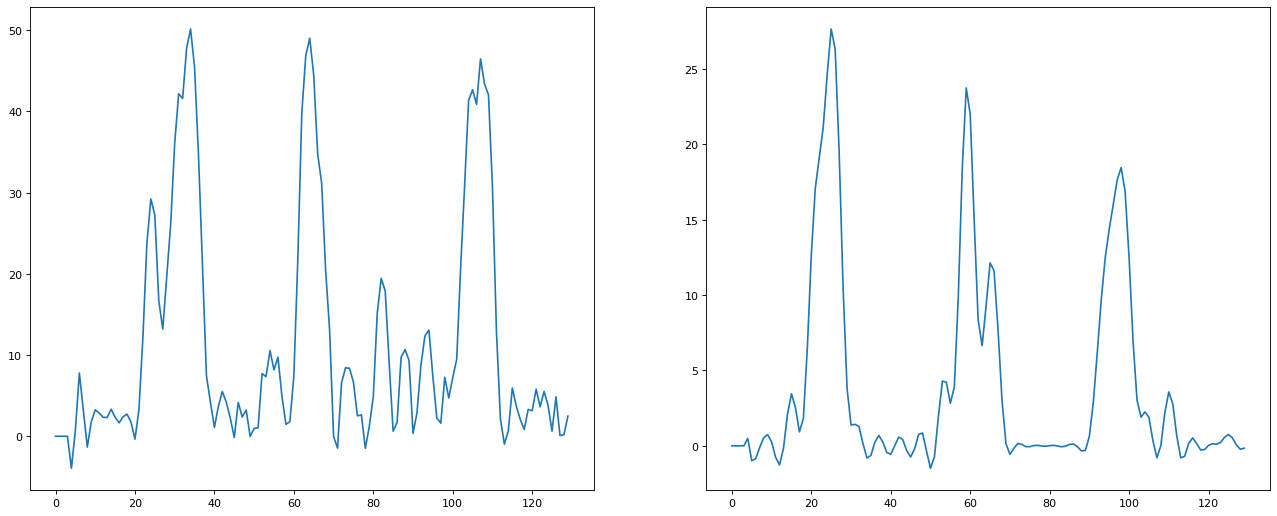

In [3]:
fig = plt.figure(figsize=(20, 8), dpi=80)
# reriew one of the normal signal 
plt.subplot(1,2,1)
# plt.title("normal signal",fontsize=20)
# plt.xlabel("sampling point",fontsize=15) 
# plt.ylabel("amplitude",fontsize=15)
plt.plot(normal_signal1[3])
# review one of the faulty signal
plt.subplot(1,2,2)
# plt.title("faulty signal",fontsize=20)
# plt.xlabel("sampling point",fontsize=15)
# plt.ylabel("amplitude",fontsize=15)
plt.plot(faulty_signal1[3])

在电流数据的获取过程中，标注为正常的信号可能实际上为异常信号，这是因为人工采集数据可能会有延迟，即也许刀具已经发生了过度磨损，但采集者未及时的意识到并正确的标注数据，因此我么你需要对正常数据进行数据清洗。通过观察大部分的正常信号可以看出基本所有信号分布都有一定的规律并有三个波峰，这是因为每个每一组信号的采样过程中，数控机床都刚好在工件上打下了三个孔。同时正常信号的信号的每个波峰的峰值基本都在+40～+65之间。故可以根据以下三个标准对正常数据进行清洗：
1.信号存在远小于+40或远大于+65的波峰
2.信号波动杂乱不规则 
3.信号波峰小于3个

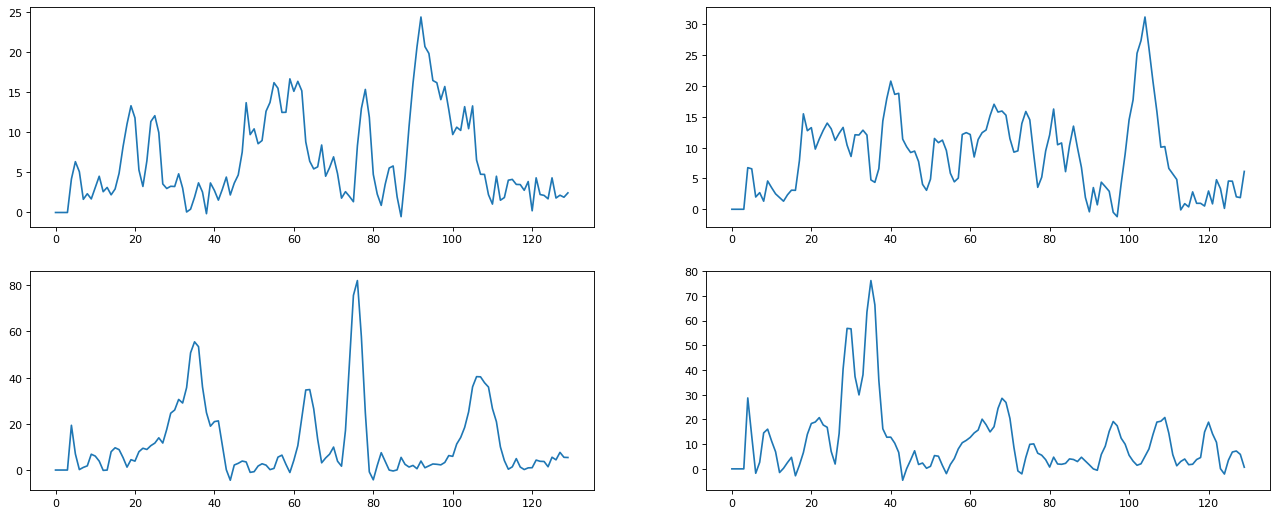

In [4]:
# data clean
fig = plt.figure(figsize=(20, 8), dpi=80)
plt.subplot(221)
plt.plot(normal_signal1[149])
plt.subplot(222)
plt.plot(normal_signal1[244])
plt.subplot(223)
plt.plot(normal_signal1[208])
plt.subplot(224) 
plt.plot(normal_signal2[255])

通过观察正常数据，以上四组数据有比较明显的异常特征，因此从正常数据中剔除 

In [5]:
# delete possible faulty data set from normal data set 
normal_signal1 = np.delete(normal_signal1,[149,208,244],axis=0)
normal_signal2 = np.delete(normal_signal2,[255],axis=0)

In [6]:
normal_signal2.shape

(503, 130)

In [7]:
# label dataset 
normal_signal1 = np.column_stack((normal_signal1,np.zeros((382,1))))#normal: 0
normal_signal2 = np.column_stack((normal_signal2,np.zeros((503,1))))#normal: 0
faulty_signal1 = np.column_stack((faulty_signal1,np.ones((6,1))))#faulty: 1
faulty_signal2 = np.column_stack((faulty_signal2,np.ones((5,1))))#faulty: 1

In [8]:
# create dataset for each process 
process_signal1 = np.vstack((normal_signal1,faulty_signal1))
process_signal2 = np.vstack((normal_signal2,faulty_signal2))
# merge normal and faulty signal repectively
normal_signal = np.vstack((normal_signal1,normal_signal2))
faulty_signal = np.vstack((faulty_signal1,faulty_signal2))
# merge all the data
data = np.vstack((normal_signal1,normal_signal2,faulty_signal1,faulty_signal2))

In [9]:
# split orginal dataset
otrain_normal,otest_normal = train_test_split(normal_signal,test_size=0.2)
otrain_normal,ovalid_normal = train_test_split(otrain_normal,test_size=0.25)
otrain_faulty,otest_faulty = train_test_split(faulty_signal,test_size=0.2)
otrain_faulty,ovalid_faulty = train_test_split(otrain_faulty,test_size=0.25)

otrain_data = np.random.permutation(np.vstack((otrain_normal,otrain_faulty)))
otest_data = np.random.permutation(np.vstack((otest_normal,otest_faulty)))
ovalid_data = np.random.permutation(np.vstack((ovalid_normal,ovalid_faulty)))

In [226]:
# reduce the dimention of data to 2 through t-sne
ts1 = TSNE(n_components=2,init='pca', random_state=1)
ts1.fit_transform(data[:,0:130])
data_2d = ts1.embedding_

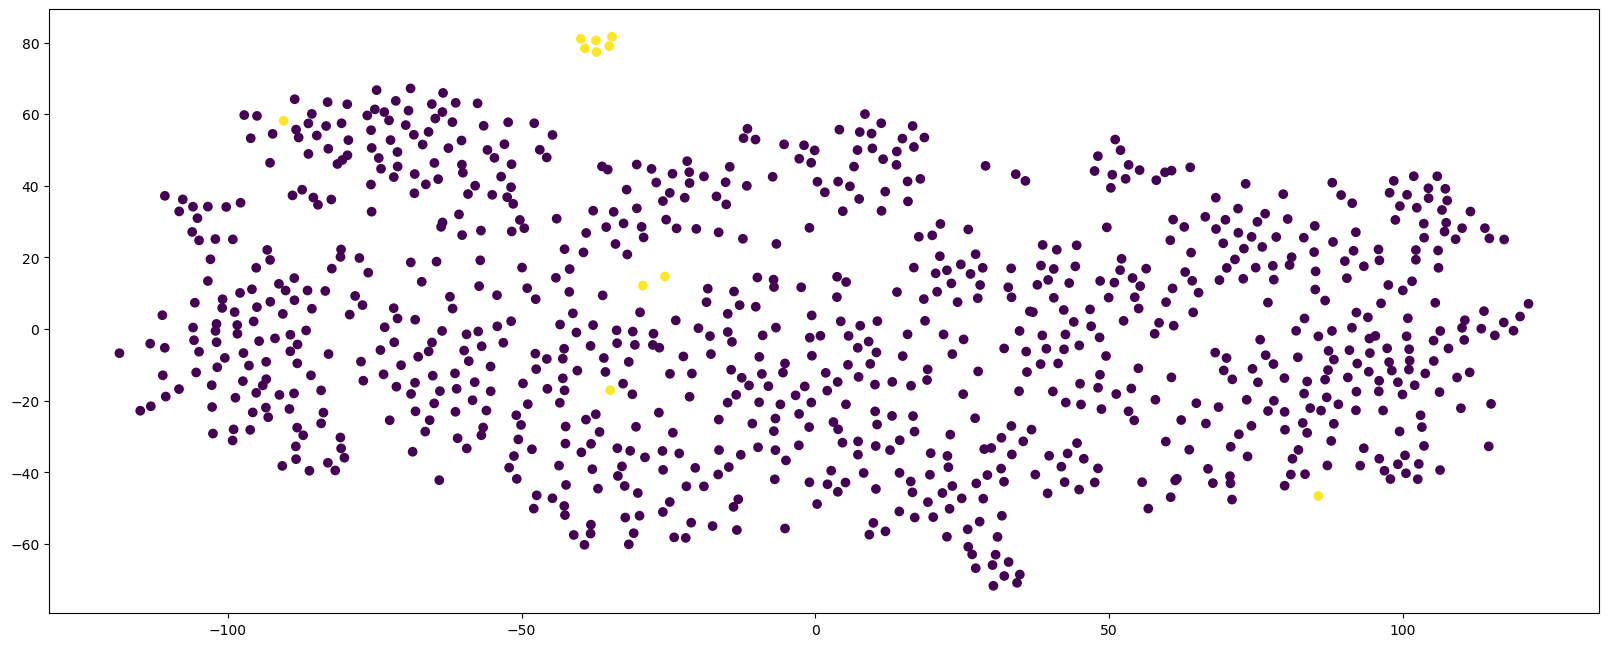

In [227]:
# draw scatter figure for data_2d 
d1 = []
d2 = []
label = []

for i in data_2d:
    x = i[0]
    y = i[1]
    d1.append(x)
    d2.append(y)
    
label = list(data[:,130])

fig = plt.figure(figsize=(20,8), dpi=100)
plt.scatter(d1,d2,c=label)

# 构造新数据集

In [228]:
# resample by adasyn
X_resampled_adasyn, y_resampled_adasyn = ADASYN(random_state=2).fit_sample(data[:,0:130], data[:,130])
# draw scatter figure for resampled data 
ts2 = TSNE(n_components=2,init='pca', random_state=3)
ts2.fit_transform(X_resampled_adasyn)
X_resampled_adasyn_2d = ts2.embedding_

Text(0.5, 1.0, 'after ADASYN')

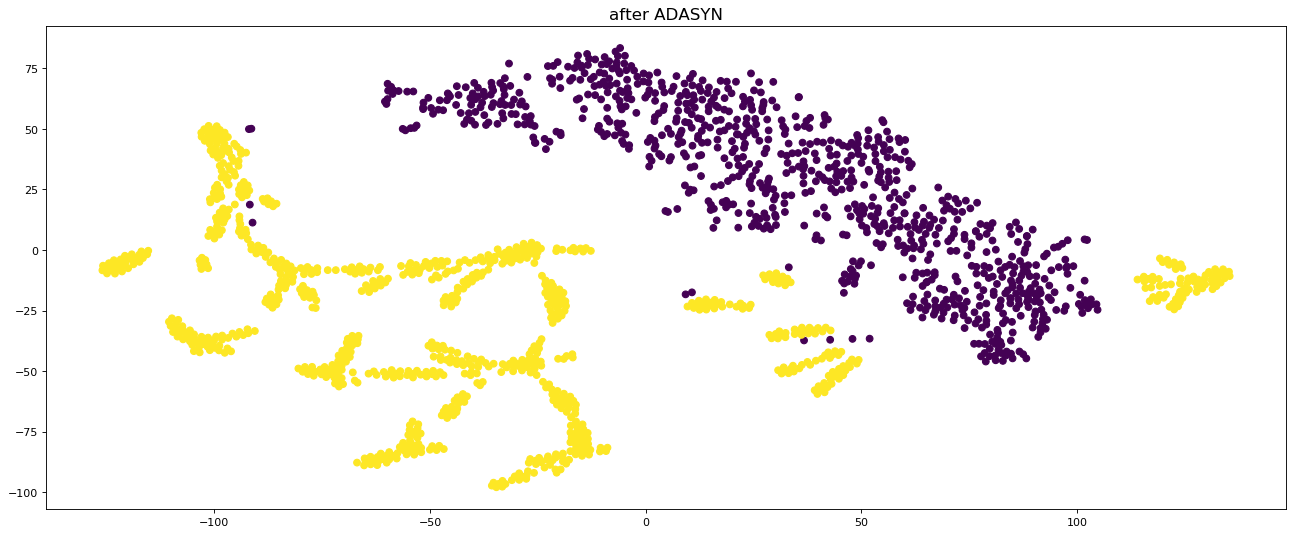

In [229]:
# draw scatter figure for data_2d 
d1 = []
d2 = []
label = []

for i in X_resampled_adasyn_2d:
    x = i[0]
    y = i[1]
    d1.append(x)
    d2.append(y)
    
label = list(y_resampled_adasyn)

fig = plt.figure(figsize=(20, 8), dpi=80)
plt.scatter(d1,d2,c=label)
plt.title("after ADASYN",fontsize=15)

In [230]:
# resample by TomekLinks
X_resampled_tom, y_resampled_tom = TomekLinks(sampling_strategy='all').fit_sample(X_resampled_adasyn, y_resampled_adasyn)
# draw scatter figure for resampled data 
ts3 = TSNE(n_components=2,init='pca', random_state=4)
ts3.fit_transform(X_resampled_tom)
X_resampled_tom_2d = ts3.embedding_

Text(0.5, 1.0, 'generative data')

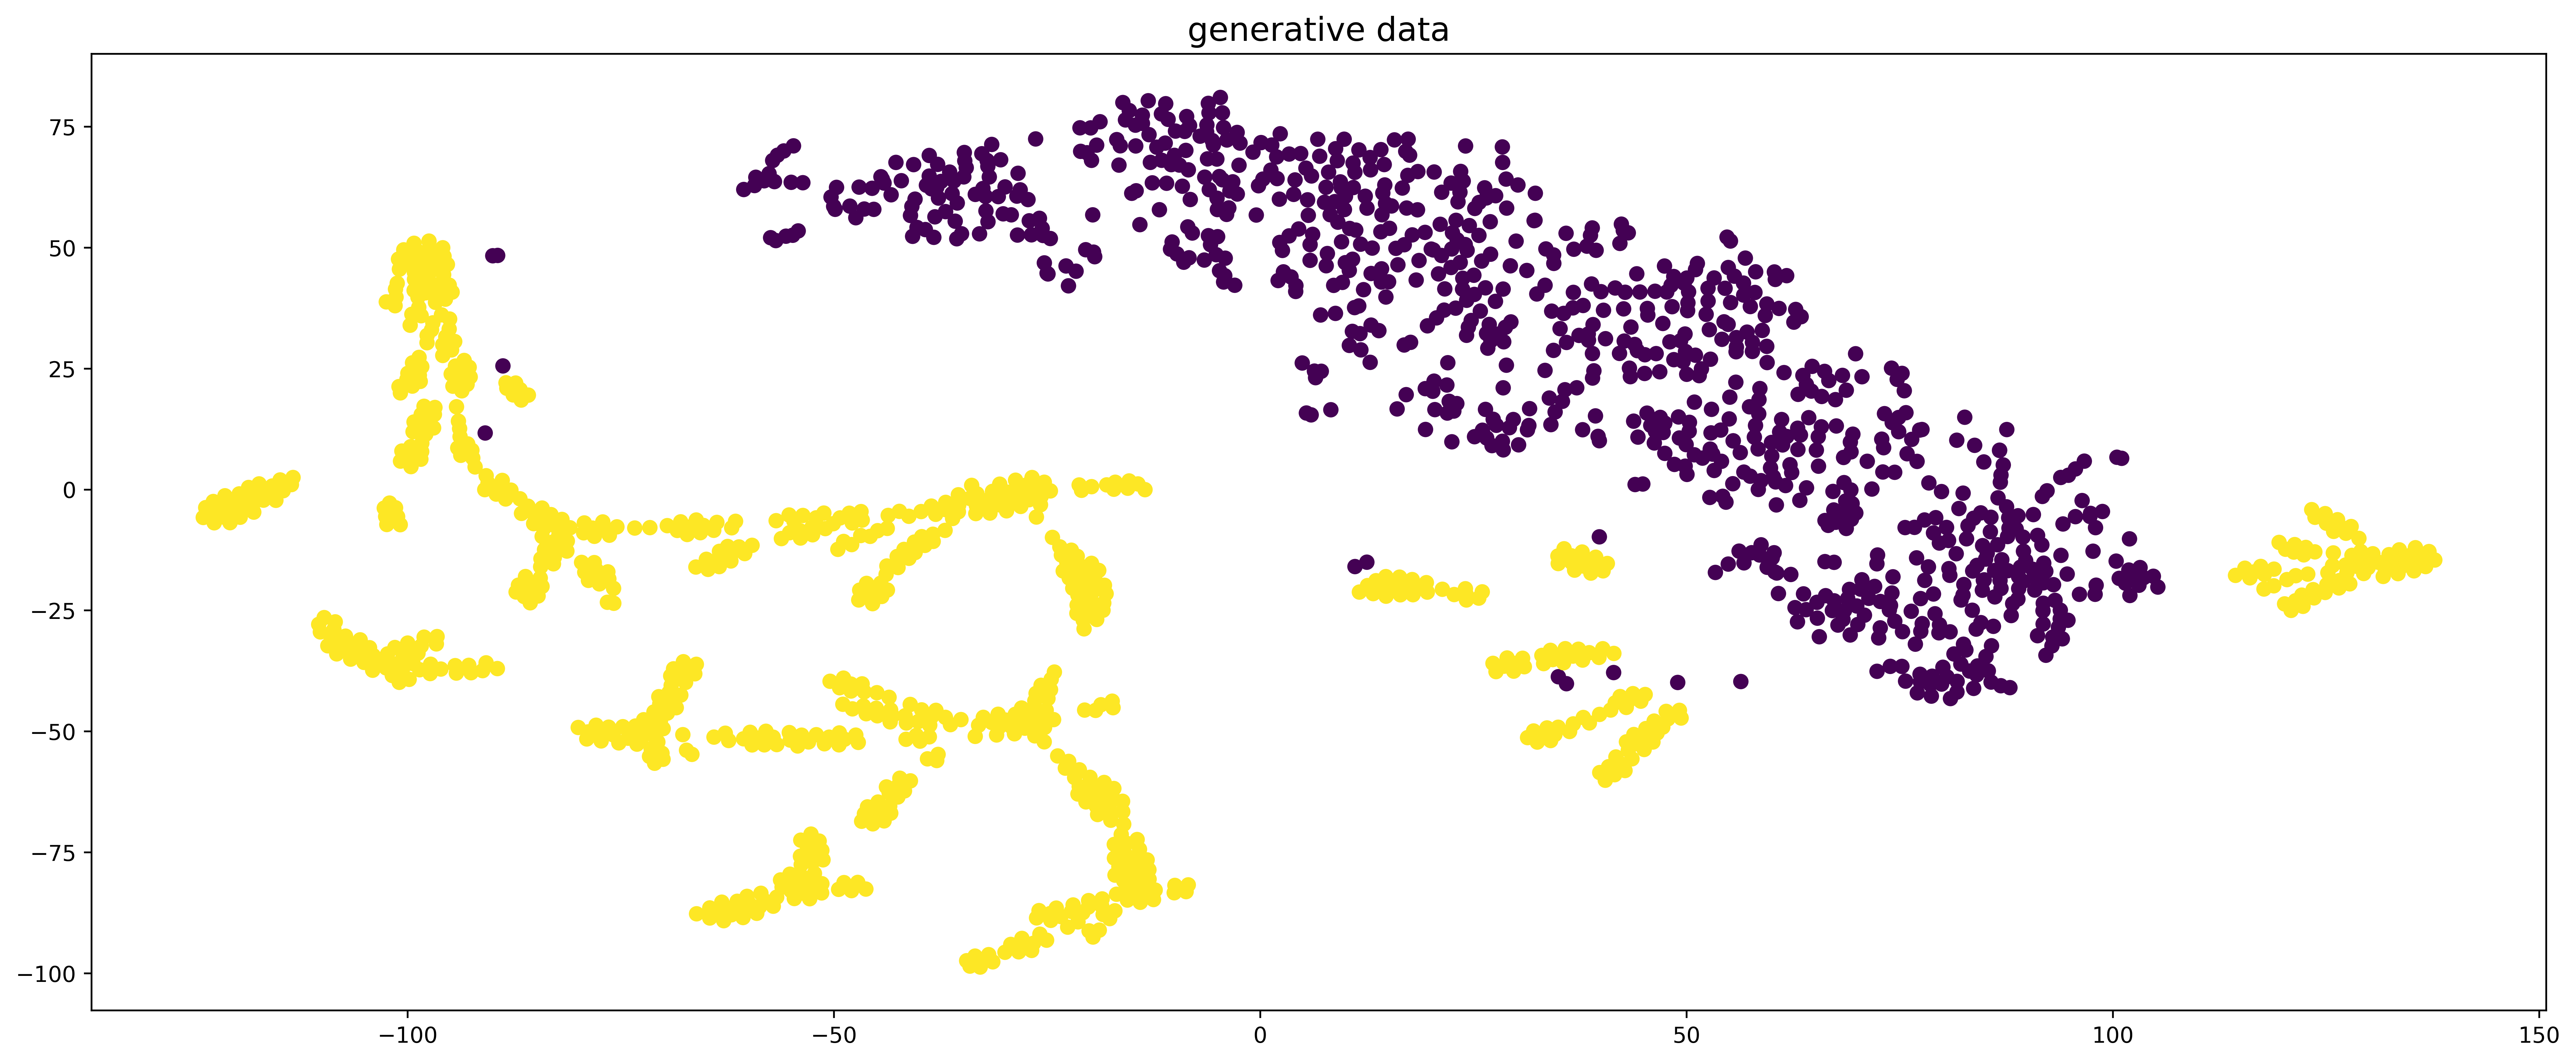

In [235]:
# draw scatter figure for data_2d 
d1 = []
d2 = []
label = []

for i in X_resampled_tom_2d:
    x = i[0]
    y = i[1]
    d1.append(x)
    d2.append(y)
    
label = list(y_resampled_tom)

fig = plt.figure(figsize=(20, 8), dpi=500)
plt.scatter(d1,d2,c=label)
plt.title("generative data",fontsize=15)

In [232]:
# make data random 
data = np.random.permutation(np.column_stack((X_resampled_tom,y_resampled_tom)))
# data split 
gtrain_data,gtest_data = train_test_split(data,test_size=0.2,random_state=5)
gtrain_data,gvalid_data = train_test_split(gtrain_data,test_size=0.25,random_state=6)

In [233]:
ts4 = TSNE(n_components=2,init='pca', random_state=4)
ts4.fit_transform(gtest_data)
gtest_data_2d = ts4.embedding_

# 数据保存

In [54]:
# save data
pd.DataFrame(pd.DataFrame(otrain_data)).to_csv('../data/original training data.csv',index=False)
pd.DataFrame(pd.DataFrame(otest_data)).to_csv('../data/original test data.csv',index=False)
pd.DataFrame(pd.DataFrame(ovalid_data)).to_csv('../data/original valid data.csv',index=False)
pd.DataFrame(pd.DataFrame(gtrain_data)).to_csv('../data/generative training data.csv',index=False)
pd.DataFrame(pd.DataFrame(gtest_data)).to_csv('../data/generative test data.csv',index=False)
pd.DataFrame(pd.DataFrame(gvalid_data)).to_csv('../data/generative valid data.csv',index=False)
pd.DataFrame(pd.DataFrame(process_signal1)).to_csv('../data/process signal1.csv',index=False)
pd.DataFrame(pd.DataFrame(process_signal2)).to_csv('../data/process signal2.csv',index=False)